In [1]:


if __name__ == "__main__":
    if len(sys.argv) < 2:
        print('Wrong input. Please enter a folder path.')
        sys.exit(1)
    filepaths = sys.argv[1:]
    for filepath in filepaths:
        recommend(filepath)


NameError: name 'sys' is not defined

In [2]:
# import libaries
from keras.backend.tensorflow_backend import set_session
import keras
import tensorflow as tf
from PIL import Image as pil_image
from vgg16_preprocess import preprocess_input as vgp
from keras.applications.resnet50 import preprocess_input as rs50
from keras.models import model_from_json
from keras_preprocessing.image import load_img, img_to_array
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sys
import os
# disable tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
# ~ import warnings
#~ warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
# disable tensorflow logging
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# allows the computer to use GPU to run the model
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU, necessary for RTX cards
config.gpu_options.allow_growth = True
# to log device placement (on which device the operation ran)
config.log_device_placement = False
sess = tf.Session(config=config)
# set this TensorFlow session as the default session for Keras
set_session(sess)
keras.backend.get_session().run(tf.global_variables_initializer())

In [4]:
class ProductRecommender:
    def __init__(self):
        self.vgg_16 = []
        self.resnet = []

    def load_model(self, vgg16_model, resnet_model, weight_lists):
        """
         # Arguments
             resnet_model, vgg16_model: json model path for resnet50 and vgg16.
              weight_lists: nested file path to saved best weights as h5.
        """
        # load json and create model and load weights
        for i, model in enumerate([vgg16_model, resnet_model]):
            for weight in weight_lists[i]:  # vgg first then resnet
                # vgg first
                if not i:
                    json_file = open(model, 'r')
                    loaded_model_json = json_file.read()
                    json_file.close()
                    loaded_model = model_from_json(loaded_model_json)
                    # hat, beard, eyewear
                    loaded_model.load_weights(weight)
                    self.vgg_16.append(loaded_model)
                else:
                    json_file = open(model, 'r')
                    loaded_model_json = json_file.read()
                    json_file.close()
                    loaded_model = model_from_json(loaded_model_json)
                    # hat, beard, eyewear
                    loaded_model.load_weights(weight)
                    self.resnet.append(loaded_model)

    def cropping(self, file_path):
        """Crops faces from a pic.
        # Arguments
            file_path: file_path to each pic.
        # Returns
            a list of cropped images of faces for each pic.
        """
        # load pic
        pic = face_recognition.load_image_file(file_path)
        # obtain list of images with tuples, 4 points
        # (ymin,xmax,ymax,xmin)
        face_locations = face_recognition.face_locations(pic)
        # intialize an empty list of available faces
        faces = []
        for loc in face_locations:
            delta_y = loc[2] - loc[0]
            delta_x = loc[1] - loc[3]
            # experimented to find a good width for hats and beard
            y_width = 2.5*delta_y
            x_increase = int((y_width*0.7 - delta_x)/2)
            y_increase = 1.25*delta_y/2
            y_min = loc[0]-int(y_increase)
            y_max = loc[2]+int(y_increase*0.4)
            x_min = loc[3]-x_increase
            x_max = loc[1]+x_increase
            # make sure not to go out of range
            if x_min < 0:
                x_min = 0
            if x_max > pic.shape[1]:
                x_max = pic.shape[1]
            if y_min < 0:
                y_min = 0
            if y_max > pic.shape[0]:
                y_max = pic.shape[0]
            faces.append(pic[y_min:y_max, x_min:x_max, :])
        return faces

    def plot_image(self, imagepath):
        '''
        inputs:
        imagepath: path to image 
        returns:
        plot image
        '''
        img = load_img(imagepath, target_size=(512, 512))
        img = img_to_array(img)
        img = img/255
        plt.imshow(img)
        plt.axis('off')

    def recommend(self, filepath):
        """recommends most relevant product to each IG user picture folder.
           Products are eyewear, hat, and beard.
        # Arguments
             filepath: IG user picture folder file path.
        """
        if os.path.isfile(filepath):
            files = [filepath]
        else:
            files = [os.path.join(filepath, file)
                     for file in os.listdir(filepath) if file != '.DS_Store']
        # keep track of num eyewear, beard, hat, and total pic with faces cropped
        hat = 0
        beard = 0
        eyewear = 0
        total = 0
        # sequence of eyewear, beard, and hat
        highest_score = [0, 0, 0]
        highest_image = ['', '', '']
        for file in files:
            if len(files) == 1:  # just one image:
                print('Actual Image:')
                self.plot_image(file)
                plt.show(block=False)
                plt.pause(5)
                plt.close()
            faces = self.cropping(file)
            if not faces:
                if len(files) == 1:
                    print('No face detected')
                continue
            total += 1
            for face in faces:
                # remove identified false faces
                # assume the fake faces are less than 150 pixel
                if len(files) == 1:
                    print('After crop:')
                    plt.imshow(face)
                    plt.axis('off')
                    plt.show(block=False)
                    plt.pause(5)
                    plt.close()
                if face.shape[0] <= 150 or face.shape[1] <= 150:
                    continue
                    print(f'Analyzing image number {total}...')
                # get predicted value for both resnet50 and vgg16
                # vgg16 predictions first:
                img_v = pil_image.fromarray(face).resize((150, 150),
                                                         pil_image.NEAREST)
                img_v = np.expand_dims(img_v, axis=0)
                img_v = vgp(img_v)
                img_v = img_v/255
                # follow this exact sequence: hat, beard, eyewear
                preds_v = []
                for model in self.vgg_16:
                    pred_v = model.predict(img_v)[0][0]
                    preds_v.append(pred_v)
                # resnet50 predictions
                img_r = pil_image.fromarray(face).resize(
                    (224, 224), pil_image.NEAREST)
                img_r = np.expand_dims(img_r, axis=0)
                img_r = rs50(img_r)
                preds_r = []
                for model in self.resnet:
                    pred_r = model.predict(img_r)[0][0]
                    preds_r.append(pred_r)
                # average the two value as an ensemble method
                pred_c = np.array([preds_v, preds_r]).mean(axis=0)
                # update highest scores
                # decide if each image has hat, beard or eyewear
                if pred_c[0] >= 0.5:
                    hat += 1
                if pred_c[0] > highest_score[0]:
                    highest_image[0] = file
                    highest_score[0] = pred_c[0]
                if pred_c[1] >= 0.5:
                    beard += 1
                if pred_c[1] > highest_score[1]:
                    highest_image[1] = file
                    highest_score[1] = pred_c[1]
                if pred_c[2] >= 0.5:
                    eyewear += 1
                if pred_c[2] > highest_score[2]:
                    highest_image[2] = file
                    highest_score[2] = pred_c[2]
            # recommend products based upon most percentage per total num of pics
            # make sure total is not zero
        if total:
            index = np.argmax([hat/total, beard/total, eyewear/total])
            product = ['hat', 'beard', 'eyewear'][index]
            img_chosen = highest_image[index]
            self.plot_image(img_chosen)
            plt.title(f"We recommend {product} products to this IG user!")
            plt.show(block=False)
            plt.pause(3)
            plt.close()

In [5]:
# initialize the 6 models outside the recommend function to speed up process:
model_path_v = '../tuning_data/VGG_16_tuning/vgg_model.json'
file_path_v = '../tuning_data/VGG_16_tuning/'
eyewear_v = file_path_v+'best_vgg16_model_eyewear.h5'
hat_v = file_path_v+'best_vgg16_model_hat.h5'
beard_v = file_path_v+'best_vgg16_model_beard.h5'
model_path_r = '../tuning_data/resnet_data/resnet50_model_5_up.json'
file_path_r = '../tuning_data/resnet_data/untracked_resnet50/'
eyewear_r = file_path_r+'best_resnet50_model_eyewear.h5'
hat_r = file_path_r+'best_resnet50_model_hat.h5'
beard_r = file_path_r+'best_resnet50_model_beard.h5'

In [6]:
image1 = ProductRecommender()

In [7]:
image1.load_model(model_path_v, model_path_r, [
                  [hat_v, beard_v, eyewear_v], [hat_r,beard_r,eyewear_r]])

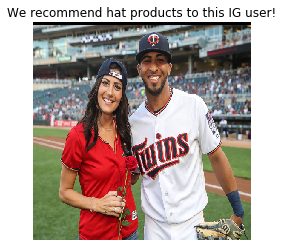

In [8]:
image1.recommend('../data/IG_photo/becca_k/')

Actual Image:


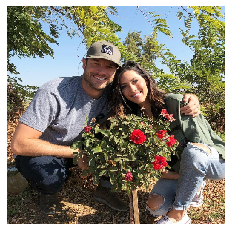

After crop:


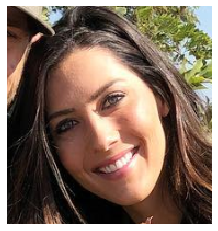

After crop:


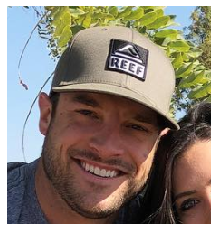

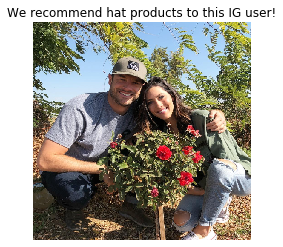

In [56]:
image1.recommend('../data/IG_photo/becca_k/15.png')